In [1]:
%load_ext autoreload

In [2]:
import os
import numpy as np
import pandas as pd
import json
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle
#sns.set(style='darkgrid')
sns.set(style='darkgrid', context='notebook',font_scale=1.5)

In [3]:
%autoreload
import sys
sys.path.insert(0,'../')
from scripts.loader import *
import mytools as tl

# Datos

In [4]:
data_path = os.path.join('..', 'Datasets', 'Interiors')
resp_path = os.path.join(data_path, 'responses')
subj_path = os.path.join(data_path, 'human_scanpaths')
figs_path = os.path.join(os.getcwd(), 'figs')

In [5]:
trials_data    = load_trials_properties(os.path.join(subj_path,'..', 'trials_properties.json'))
subjs_response = load_human_scanpaths(os.path.join(resp_path, 'human_scanpaths'))
responses_data = tl.get_responses_features(subjs_response)
responses_data = responses_data[responses_data.response_x <= 1024]
responses_data.head()

,subj,img,max_fixations,scanpath_length,target_found,target_found_response,response_size,distance_to_target,distance_to_last_fix,delta_time_response,response_x,response_y,target_bbox_x,target_bbox_y,response_target_relative_x,response_target_relative_y
0,41,grayscale_11_opensource.jpg,13,10,False,False,29,266.810794,213.164661,49.599536,486.0,447.0,228,559,-258.0,112.0
1,41,grayscale_18_housebeautiful.jpg,9,10,False,False,47,329.200547,411.615026,9.666707,520.0,538.0,797,400,277.0,-138.0
2,41,grayscale_100_oliva.jpg,5,3,True,False,19,202.054448,204.544005,5.633140,714.0,218.0,713,381,-1.0,163.0
3,41,grayscale_17_oliva.jpg,3,2,False,False,35,297.692795,208.923431,4.266648,433.0,316.0,186,490,-247.0,174.0
4,41,grayscale_16_housebeautiful.jpg,3,4,False,False,19,568.198029,223.650531,2.900187,762.0,442.0,158,421,-604.0,-21.0


# Performance acumulada

## A mano

<AxesSubplot:xlabel='max_fixations', ylabel='target_found'>

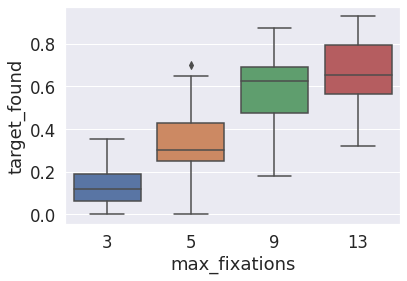

In [6]:
df=responses_data.groupby(['subj', 'max_fixations']).mean()['target_found']
sns.boxplot(data=df.reset_index(), x='max_fixations', y='target_found')

Using target found online


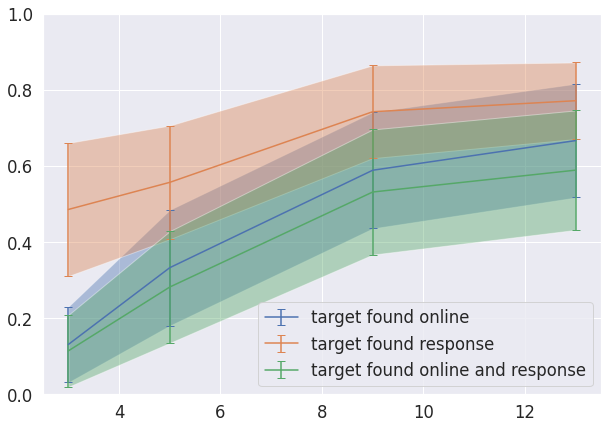

In [7]:
def cumulative_mean_performance_response(df, max_fix_key ='max_fixations', use_response=True):
    
    print('Using target found online')
    so = df.groupby(['subj', max_fix_key])['target_found'].sum()
    co = df.groupby(['subj', max_fix_key])['target_found'].count()
    perf_o = (so/co).groupby(['max_fixations']).agg(['mean', 'std'])
    
    if use_response:
        sr = df.groupby(['subj', max_fix_key])['target_found_response'].sum()
        cr = df.groupby(['subj', max_fix_key])['target_found_response'].count()
        perf_r = (sr/cr).groupby(['max_fixations']).agg(['mean', 'std'])
        # join with online target found
        perf_o = perf_o.join(perf_r, lsuffix='_online', rsuffix='_response')
        df['target_found_online_response'] = df['target_found'] & df['target_found_response']
        so_r = df.groupby(['subj', max_fix_key])['target_found_online_response'].sum()
        co_r = df.groupby(['subj', max_fix_key])['target_found_online_response'].count()
        perf_o_r = (so_r/co_r).groupby(['max_fixations']).agg(['mean', 'std'])
        # join with online target found
        perf_o = perf_o.join(perf_o_r)
        perf_o.rename(columns={'mean': 'mean_online_response', 'std': 'std_online_response'}, inplace=True)
        #perf_o.reset_index(inplace=True)
        
    return perf_o
 
aux  = cumulative_mean_performance_response(responses_data).reset_index()

_, ax = plt.subplots(1,1,figsize=(10,7))
ax.errorbar(aux['max_fixations'], aux['mean_online'], yerr = aux['std_online'], 
            label ='target found online', capsize=4)
ax.fill_between(aux['max_fixations'], 
                aux['mean_online']-aux['std_online'], 
                aux['mean_online']+aux['std_online'],
                alpha=0.4)

ax.errorbar(aux['max_fixations'], aux['mean_response'], yerr = aux['std_response'],
            label = 'target found response', capsize=4)
ax.fill_between(aux['max_fixations'], 
                aux['mean_response']-aux['std_response'], 
                aux['mean_response']+aux['std_response'], 
                alpha=0.4)

ax.errorbar(aux['max_fixations'], aux['mean_online_response'], yerr = aux['std_online_response'],
            label = 'target found online and response', capsize=4)
ax.fill_between(aux['max_fixations'],
                aux['mean_online_response']-aux['std_online_response'], 
                aux['mean_online_response']+aux['std_online_response'], alpha=0.4)

ax.set_ylim(0,1)
ax.legend()

plt.savefig(os.path.join(figs_path, f'lineplot_performance_responses.png'))

In [8]:
responses_data.scanpath_length.value_counts()

4     1432
3     1172
5     1017
6      783
2      482
8      465
7      464
9      420
10     313
12     227
13     213
11     179
14     141
Name: scanpath_length, dtype: int64

## Usando las funciones del repo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Cumulative performance] Computing human mean for Interiors dataset


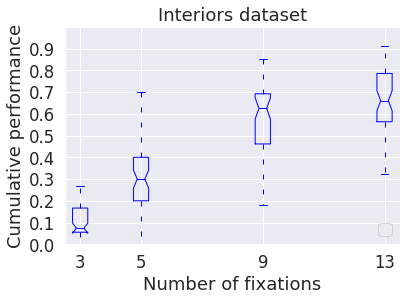

In [9]:
%autoreload
from Metrics.scripts.cumulative_performance import CumulativePerformance
perf = CumulativePerformance(dataset_name='Interiors', number_of_images=134, max_scanpath_length=15, compute=True)
#perf.compute_cumulative_performance(subjs_response[42])
perf.add_human_mean(humans_scanpaths_dir=os.path.join(resp_path, 'human_scanpaths'), humans_color='blue')
#perf.add_human_mean(humans_scanpaths_dir=subj_path, humans_color='blue')
perf.plot(save_path=figs_path)

# Performance: scanpath + respuesta

In [10]:
%pip install multimatch_gaze

Note: you may need to restart the kernel to use updated packages.


In [11]:
from Metrics import main as hspmetric



TypeError: 'module' object is not callable